In [1]:
%pip install numpy scipy scikit-learn matplotlib

from numpy.linalg import LinAlgError
from scipy.sparse import csr_matrix, lil_matrix
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR, SVC, LinearSVC ,OneClassSVM
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math


Note: you may need to restart the kernel to use updated packages.


In [ ]:
class NBCS(BaseEstimator, TransformerMixin): #(BaseEstimator,RegressorMixin):

    def __init__(self,C=1,k=1,type="barry",tolerance = 0.1):
        self.C=C
        self.k =k
        self.type=type
#         if type == "barry":
#             print(1)
#             self.tolerance = 3
#             self.fit=self.fit_barry
            
#         elif type == "adapt_class":
#             print(1)
#             self.tolerance = 10
#             self.fit= self.fit_adapt_class

#         elif type == "adapt_reg":
#             print(2)
#             self.tolerance = 0.1
#             self.fit= self.fit_adapt_reg
        
            
    def fit(self, X, y=None ):
        if (X.min() < 0 or X.max() > 1):
            raise TypeError("data must be scaled from 0 to 1")
            
        if self.type == "barry":
            self.tolerance = 3
            return self.fit_adapt_ocs(X,y)
            return self.fit_barry2(X,y)
            
        elif  self.type == "adapt_class":
            self.tolerance = 10
            return self.fit_adapt_class(X,y)

        elif self.type == "adapt_reg":
            self.tolerance = 0.1
            return self.fit_adapt_reg(X,y)
        
        elif self.type == "adapt_ocs":
            self.tolerance = 3
            return self.fit_adapt_ocs(X,y)
        
        return self


    def add_point(self,point):
        index, r = self.find_point(point)
        self.list=np.concatenate((self.list ,[point]))
        new=np.zeros(point.shape[0]+1,dtype=int)
        combinations = np.array(list(itertools.combinations(self.indicies[index], point.shape[0])))
        for simplex in combinations:
            simplex=np.concatenate((simplex,[self.list.shape[0]-1]))
            new=np.vstack((new,simplex))

        self.indicies=np.vstack((self.indicies,new[1:,:]))
        self.indicies=np.delete(self.indicies,index,0)


    def transform(self,X):
        d = lil_matrix((X.shape[0], self.list.shape[0]))
        self.category=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            try:
                j,r = self.find_point(X[i, :])
                d[i, self.indicies[j]] = r
                self.category[i]=j
            except TypeError:
                print("type error:",i,X[i, :])
            except IndexError:
                print("index error:", i,X[i, :])
        return d

    def find_point(self, pts):
        "returns which simplex you belong to and with  coefficients"
        for j in range(self.indicies.shape[0]):
            h = np.vstack([self.list[self.indicies[j]].T, np.ones(len(pts) + 1)])
            s = np.append(pts, 1)
            try:
                r = np.linalg.solve(h, s)
            except LinAlgError:
                print(h,s)
            flag = 1
            for alpha in r:
                if alpha < -1e-3:
                    flag = 0
                    break
            if (flag == 1):
                return j , r


    def fit_barry(self, X, y=None ):
#         self.list = np.zeros([X.shape[1],X.shape[1]+1])
#         for dim in range(X.shape[1]):
#             self.list[dim,dimnp.max(X[:,dim])
        
        self.list = np.eye(X.shape[1]) * X.shape[1]
        self.list = np.vstack([np.zeros(X.shape[1]), self.list])
        # self.list = np.array([[0, 0], [0, 2], [2, 0]])
        self.indicies = np.array([np.arange(X.shape[1] + 1)])

        for itr in range(self.k):
            indicies=self.indicies[:]
            d = self.transform(X)

            for simplex in range(indicies.shape[0]):
                 q = (self.category == simplex)
                 if not any(q) or X[q].shape[0] < self.tolerance:
                     continue
                 self.add_point(np.mean(self.list[indicies[simplex]],axis=0))
        return self

    def fit_barry2(self, X, y=None ):
#         self.list = np.zeros([X.shape[1],X.shape[1]+1])
#         for dim in range(X.shape[1]):
#             self.list[dim,dimnp.max(X[:,dim])
        
        self.list = np.eye(X.shape[1]) * X.shape[1]
        self.list = np.vstack([np.zeros(X.shape[1]), self.list])
        # self.list = np.array([[0, 0], [0, 2], [2, 0]])
        self.indicies = np.array([np.arange(X.shape[1] + 1)])

        for itr in range(self.k):
            indicies=self.indicies[:]
            d = self.transform(X)

            for simplex in range(indicies.shape[0]):
                 q = (self.category == simplex)
                 if not any(q) or X[q].shape[0] < self.tolerance:
                     continue
                 self.add_point(np.mean(X[q],axis=0))
        return self

    def fit_adapt_class(self, X, y=None):
        svc = LinearSVC()
        self.list = np.eye(X.shape[1]) * X.shape[1]
        self.list = np.vstack([np.zeros(X.shape[1]), self.list])
        # self.list = np.array([[0, 0], [0, 2], [2, 0]])
        self.indicies = np.array([np.arange(X.shape[1] + 1)])
        for iter in range(self.k):
            indicies = self.indicies[:]
            d = self.transform(X)
            svc.fit(d, y)
            for simplex in range(indicies.shape[0]):
                q = (self.category == simplex)
                if not any(q):
                    continue
                X1 = X[q]
                y1 = y[q]
                d1 = d[q]
                p = (svc.predict(d1) != y1)
                if not any(p) or X1[p].shape[0] < self.tolerance:
                    continue
                self.add_point(np.mean(X1[p],axis=0))
        return self
    
    def fit_adapt_reg(self,X,y): 
        clf=LinearRegression()
        self.list = np.eye(X.shape[1]) * X.shape[1]
        self.list = np.vstack([np.zeros(X.shape[1]), self.list])
        # self.list = np.array([[0, 0], [0, 2], [2, 0]])
        self.indicies = np.array([np.arange(X.shape[1] + 1)])
        for iter in range(self.k):
            indicies = self.indicies[:]
            d = self.transform(X)
            clf.fit(d, y)
            for simplex in range(indicies.shape[0]):
                q = (self.category == simplex)
                if not any(q):
                    continue
                X1 = X[q]
                y1 = y[q]
                d1 = d[q]
                p = np.argmin(y1-clf.predict(d1))
                elem=X1[p]
                if any(np.linalg.norm(q-elem)<self.tolerance  for q in self.list):
                    continue                                    
                if np.isin(elem,self.list) or X1.shape[0] < 3:
                    continue
                self.add_point(elem)
        return self

    def fit_adapt_ocs(self, X, y=None):
        ocs =  OneClassSVM(nu=0.1, kernel="linear")
        self.list = np.eye(X.shape[1]) * X.shape[1]
        self.list = np.vstack([np.zeros(X.shape[1]), self.list])
        # self.list = np.array([[0, 0], [0, 2], [2, 0]])
        self.indicies = np.array([np.arange(X.shape[1] + 1)])
        for iter in range(self.k):
            indicies = self.indicies[:]
            d = self.transform(X)
            ocs.fit(d, y)
            for simplex in range(indicies.shape[0]):
                q = (self.category == simplex)
                if not any(q):
                    continue
                X1 = X[q]
                d1 = d[q]
                p = ocs.decision_function(d1)<0
                if not any(p) or X1[p].shape[0] < self.tolerance:
                    continue
                self.add_point(np.mean(X1[p],axis=0))
        return self   
    


# classification


In [3]:
def make_meshgrid(x, y, h=.01):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() , x.max()
    y_min, y_max = y.min() , y.max()



    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xy,**params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# ########################################

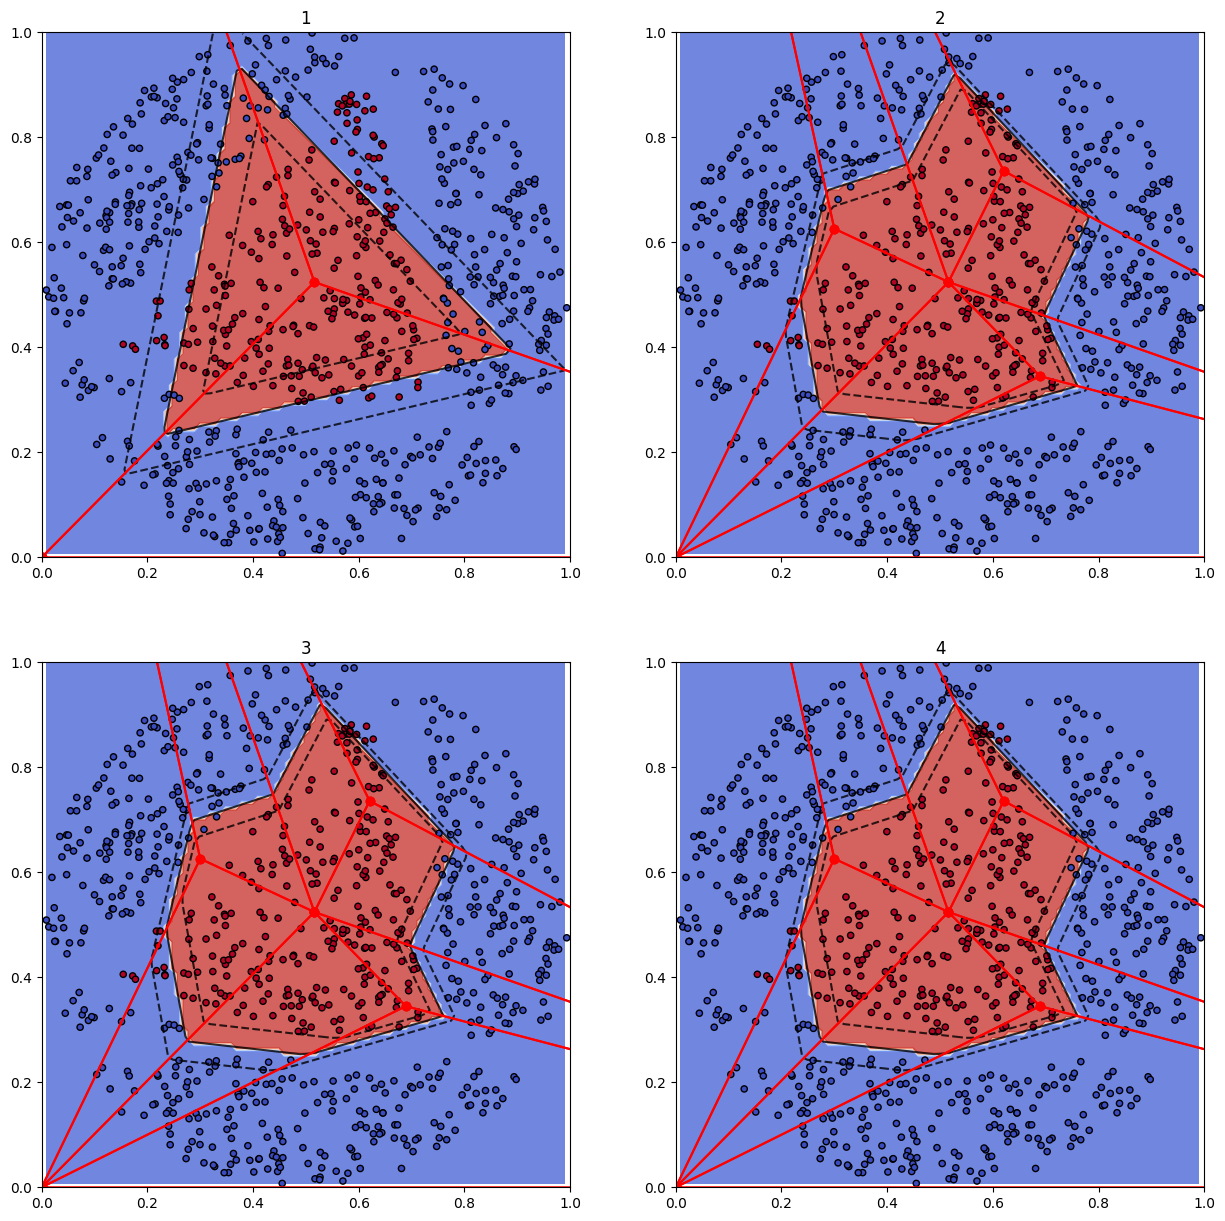

In [4]:
#######    regular polytope code  

N=1000
C=1000
gamma=0.01
D=2 #dimension
t=8 #polytope order

X = np.random.normal(0,1,(N,D))
ws= np.random.normal(0,1,(t,D))
ws = ws / (np.linalg.norm(ws,axis=1).reshape(-1,1))

u=np.random.uniform(0,1,(N,1))
X=X/(np.linalg.norm(X,axis=1).reshape(-1,1))*(u**(1/D))

y=np.ones(N)

for index in range(N):
    z = 1
    for w in ws :
        if((X[index].dot(w)- 0.5 - gamma) > 0):
            z = -1
        else :
            if ((X[index].dot(w) - 0.4 -gamma) > 0):
                z =0
    y[index]=z

X=(X[y!= 0]+ [1,1])/2
y=y[y!= 0]

fig, sub = plt.subplots(2, 2, figsize=(15, 15))
#plt.subplots_adjust(wspace=0.6, hspace=0.6 )

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
for k, title, ax in zip(range(1,5), range(1,5), sub.flatten()):

    model = NBCS(C,k=k,type="adapt_class")
    embedder = model.fit(X, y)
    points=embedder.transform(X)
    clf=SVC(C=C, kernel='linear').fit(points,y)
    # plot the decision function
    xy = embedder.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, clf, xx, yy,xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0 ,1)
    ax.set_title(title)

    # # plot decision boundary and margins
    Z = clf.decision_function(xy).reshape(xx.shape)
    ax.contour(xx,yy, Z, colors='k', levels=[-1,0,1], alpha=0.8,
                linestyles=['--', '-', '--'])

    x1 = np.concatenate((model.list[:, 0], [0]))
    x2 = np.concatenate((model.list[:, 1], [0]))

    for i in model.indicies:
        i=np.concatenate((i,[i[0]]))
        ax.plot(x1[i], x2[i], 'ro-')
plt.show()

# regression

In [5]:
def plot_reg(x,y):
    K =[1,2,4]
    clf = LinearRegression()
    fig, sub = plt.subplots(1,4,figsize=(10, 5))
    #plt.subplots_adjust(wspace=0.4, hspace=0.4)
    log_error = []
    a=range(7)
    for k, ax in zip(K, sub.flatten()):
        ax.plot(x, y,'.')
        ax.set_title("%d steps" % k)
        z = NBCS(k=k,type="adapt_reg").fit(x,y)#
       # z = NBCS(k=k).fit_barry(x) #
        points = z.transform(x)
        clf.fit(points, y)
        ax.plot(x, clf.predict(points), 'r')
     #   ax.plot(z.Q,np.zeros(z.Q.shape[0]),'*')
       # print("Q",z.Q)

    for k in a:
        z = NBCS(k=k,type="adapt_reg").fit(x,y)#
       # z = NBCS(k=k).fit_barry(x) #
        points = z.transform(x)
        clf.fit(points, y)
        log_error.append(math.log(1 - clf.score(points, y)))

    plt.plot(a,log_error,'*-')
    plt.xticks(a)
    plt.title('log error')

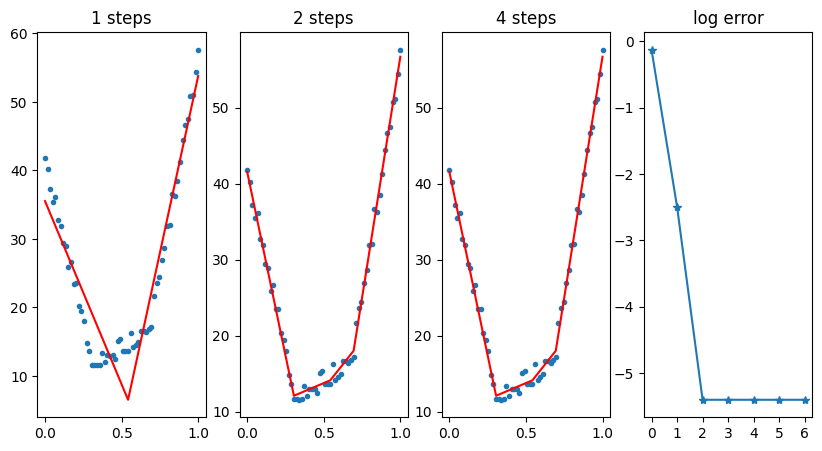

In [6]:
# regression examples
#3 lines
samlpe=20
std=3
x = np.linspace(0, 10, samlpe)
y = np.linspace(10, 20, samlpe)
z = np.linspace(20, 30, samlpe)
r=std*np.random.rand(3*samlpe)

y=np.concatenate([-3*x+40+r[0:samlpe],0.5*y+5+r[samlpe:2*samlpe],4*z-65+r[2*samlpe:3*samlpe]]).reshape(-1,1)
x=np.linspace(0, 30, 3*samlpe)
x=x.reshape(-1,1)/30
plot_reg(x,y)

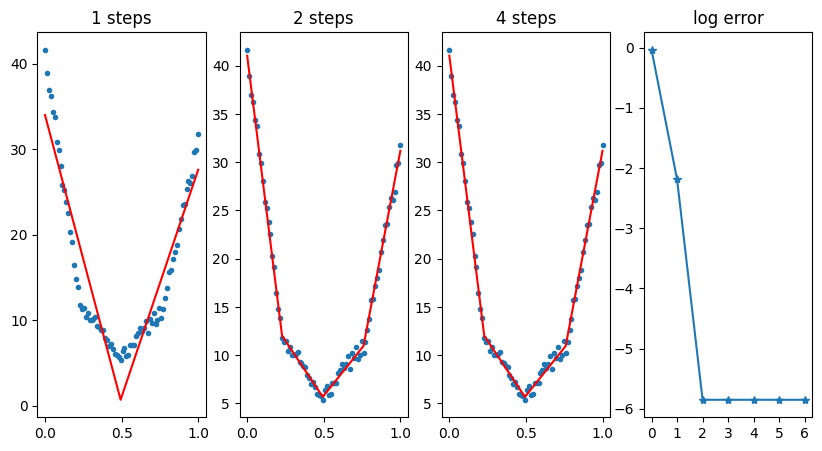

In [7]:
#4 lines
samlpe=20
std=2

x1 = np.linspace(0, 10, samlpe)
x2 = np.linspace(10, 20, samlpe)
x3 = np.linspace(20, 30, samlpe)
x4 = np.linspace(30, 40, samlpe)

r=std*np.random.rand(4*samlpe)

y=np.concatenate([-3*x1+40+r[0:samlpe],-0.5*x2+15+r[samlpe:2*samlpe],0.5*x3-5+r[2*samlpe:3*samlpe],2*x4-50+r[3*samlpe:4*samlpe]]).reshape(-1,1)
x=np.linspace(0, 40, 4*samlpe)
x=x.reshape(-1,1)/40
plot_reg(x,y)

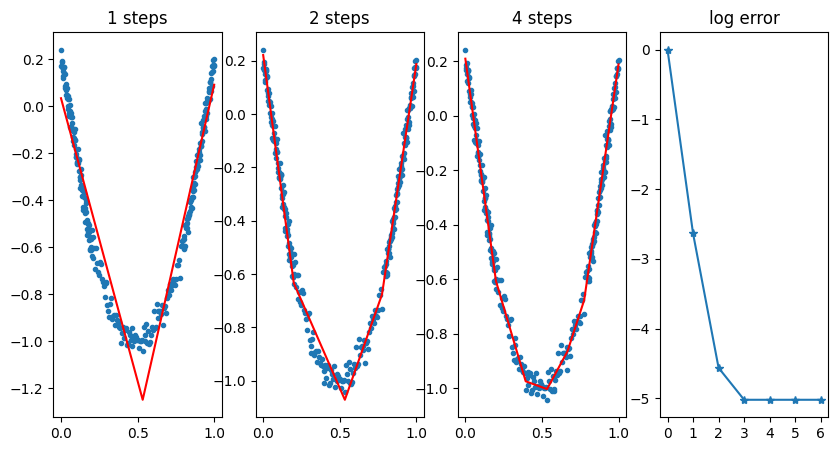

In [8]:
#sinsoid
x1 = np.linspace(0,0.2,100)
x2 = np.linspace(0.2,0.8,100)
x3 = np.linspace(0.8,1,100)
y1= -4*x1+0.2
y2 = -np.sin(np.pi*x2)
y3 = 4*x3-3.8


x=np.hstack((x1,x2,x3))
y=np.hstack((y1,y2,y3))
r=std*np.random.rand(300*samlpe)

x=x.reshape(-1,1)
y=y.reshape(-1,1)+np.random.normal(0,0.03,[x.shape[0],1])
plot_reg(x,y)

## anomaly detection

In [9]:
def plot_boundary(plot_size,boundary_size):
    # Predict
    y_pred_train = oc_svm.predict(X_train)
    y_pred_test = oc_svm.predict(X_test)
    y_pred_outliers = oc_svm.predict(X_outliers)

    # Replace -1 with 0 for anomaly detection
    y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]
    y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]
    y_pred_outliers = [0 if x == -1 else 1 for x in y_pred_outliers]

    # True labels
    y_true_train = [1] * len(y_pred_train)
    y_true_test = [1] * len(y_pred_test)
    y_true_outliers = [0] * len(y_pred_outliers)

    # Combine predictions and true labels
    y_true = y_true_train + y_true_test + y_true_outliers
    y_pred = y_pred_train + y_pred_test + y_pred_outliers

    # Print classification report
    print(classification_report(y_true, y_pred))

    # Create meshgrid for visualization
    xx, yy = np.meshgrid(np.linspace(0,1, 500), np.linspace(0,1, 500))
    Z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    plt.title("One-Class SVM for Anomaly Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')

    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=20, edgecolor='k', label='Training data')
    # Plot test data
    plt.scatter(X_test[:, 0], X_test[:, 1], c='green', s=20, edgecolor='k', label='Test data')
    # Plot outliers
    plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=20, edgecolor='k', label='Outliers')

    plt.axis('tight')
    xlim=(0,2)
    ylim=(0,2)
    plt.legend()
    plt.rcParams['figure.figsize'] = [20, 5]
       # model=oc_svm['reduce_dim']

    #x1 = np.concatenate((model.list[:, 0], [0]))
    #x2 = np.concatenate((model.list[:, 1], [0]))

    #for i in model.indicies:
     #   i=np.concatenate((i,[i[0]]))
      #  plt.plot(x1[i], x2[i], 'bo-')
    plt.show()


              precision    recall  f1-score   support

           0       0.38      0.95      0.54        20
           1       1.00      0.87      0.93       240

    accuracy                           0.88       260
   macro avg       0.69      0.91      0.74       260
weighted avg       0.95      0.88      0.90       260



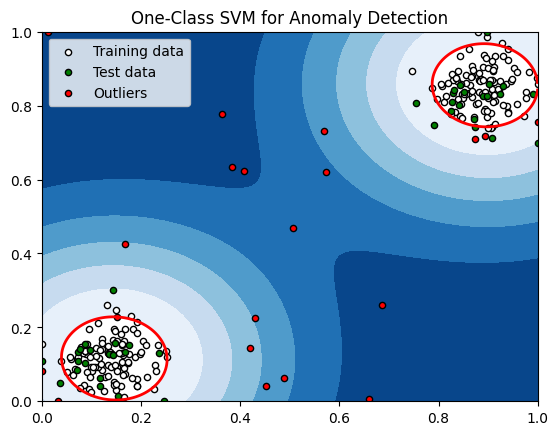

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report

# Generate synthetic data
np.random.seed(42)
X_train = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X_train + 2, X_train - 2]

X_test = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X_test + 2, X_test - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Standardize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_outliers = scaler.fit_transform(X_outliers)

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=10, nu=0.1)#gamma=10

# Train the model
oc_svm.fit(X_train)

plot_boundary(2,5)

              precision    recall  f1-score   support

           0       0.07      0.50      0.13        20
           1       0.92      0.47      0.62       240

    accuracy                           0.47       260
   macro avg       0.50      0.49      0.37       260
weighted avg       0.85      0.47      0.58       260



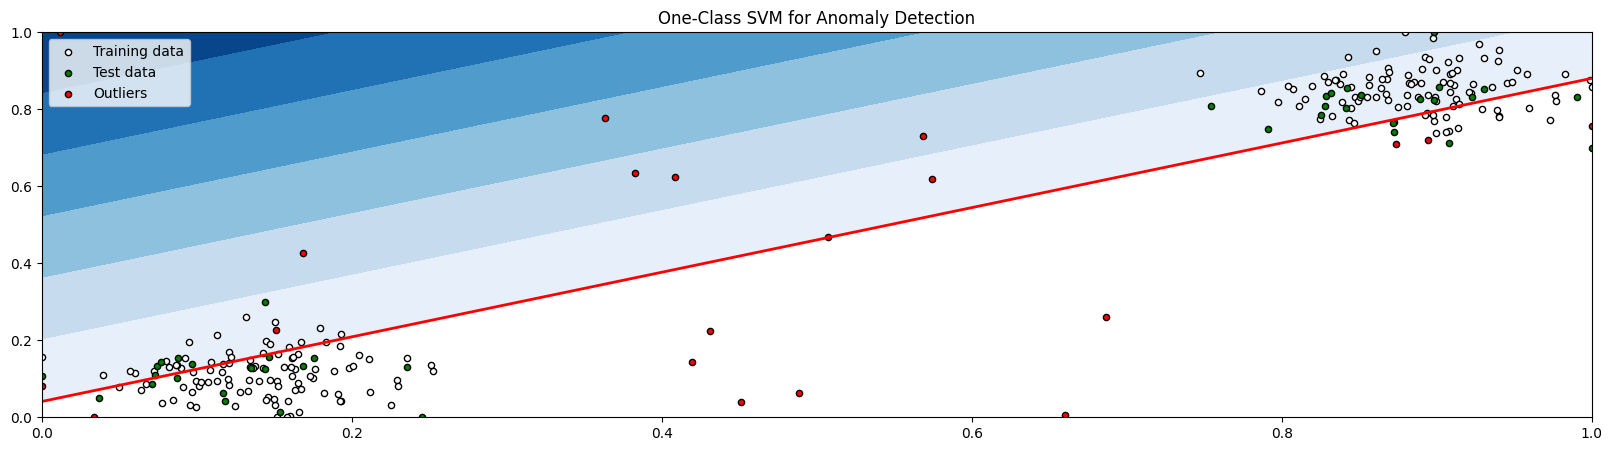

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=0,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.04      0.25      0.06        20
           1       0.88      0.45      0.60       240

    accuracy                           0.44       260
   macro avg       0.46      0.35      0.33       260
weighted avg       0.81      0.44      0.56       260



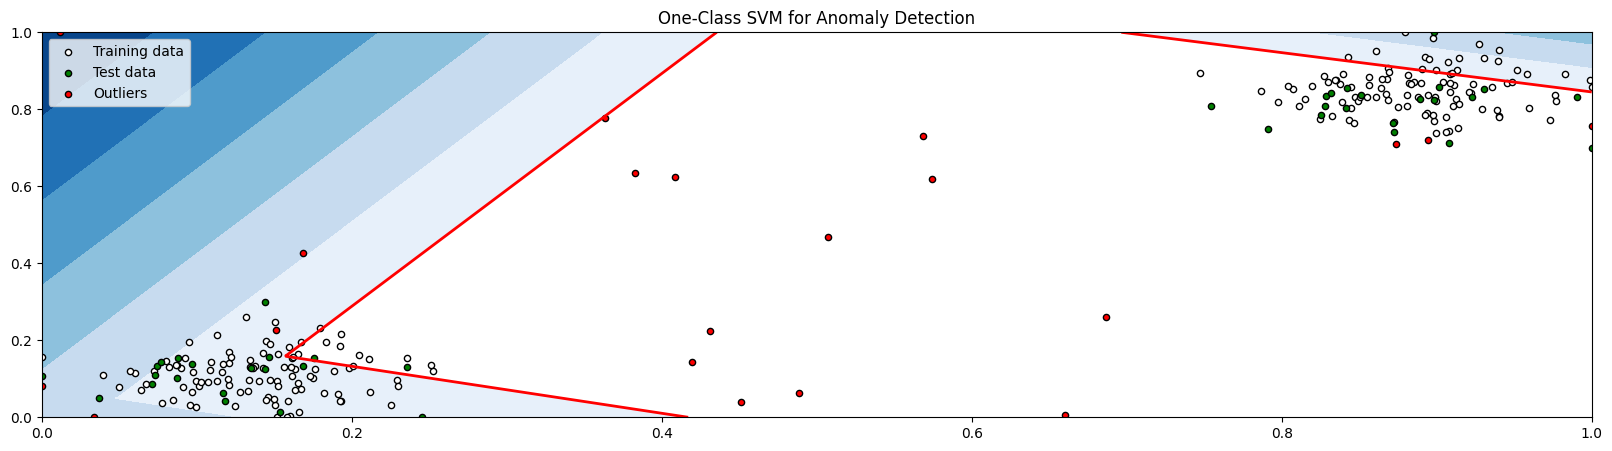

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=1,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.37      0.85      0.52        20
           1       0.99      0.88      0.93       240

    accuracy                           0.88       260
   macro avg       0.68      0.86      0.72       260
weighted avg       0.94      0.88      0.90       260



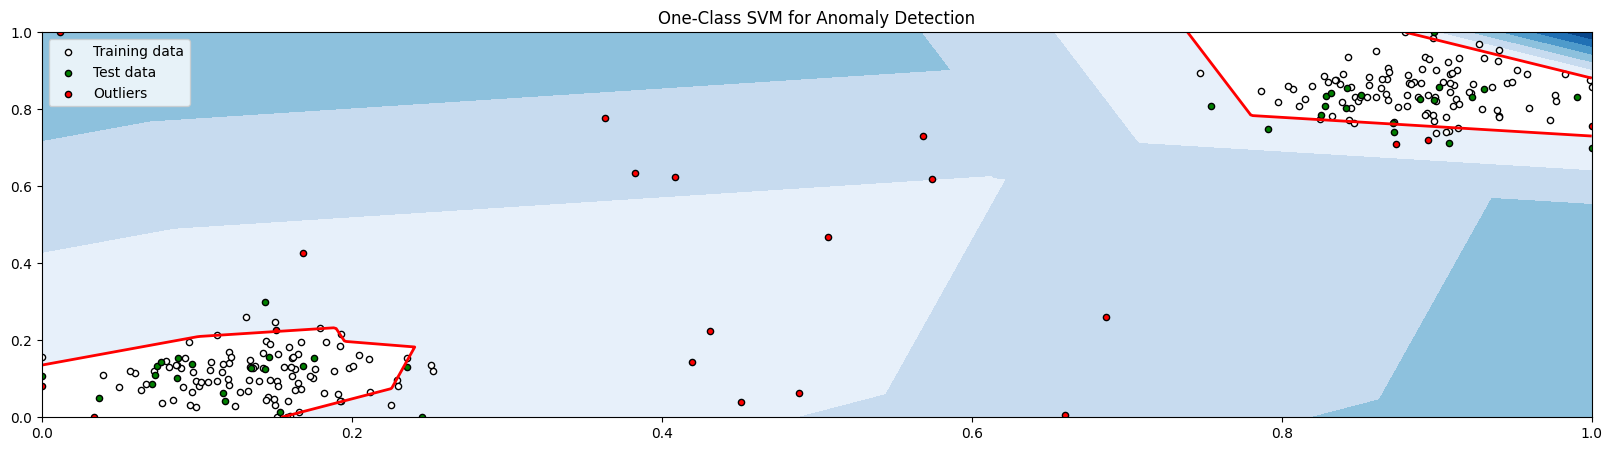

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=2,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.39      0.90      0.55        20
           1       0.99      0.88      0.93       240

    accuracy                           0.88       260
   macro avg       0.69      0.89      0.74       260
weighted avg       0.94      0.88      0.90       260



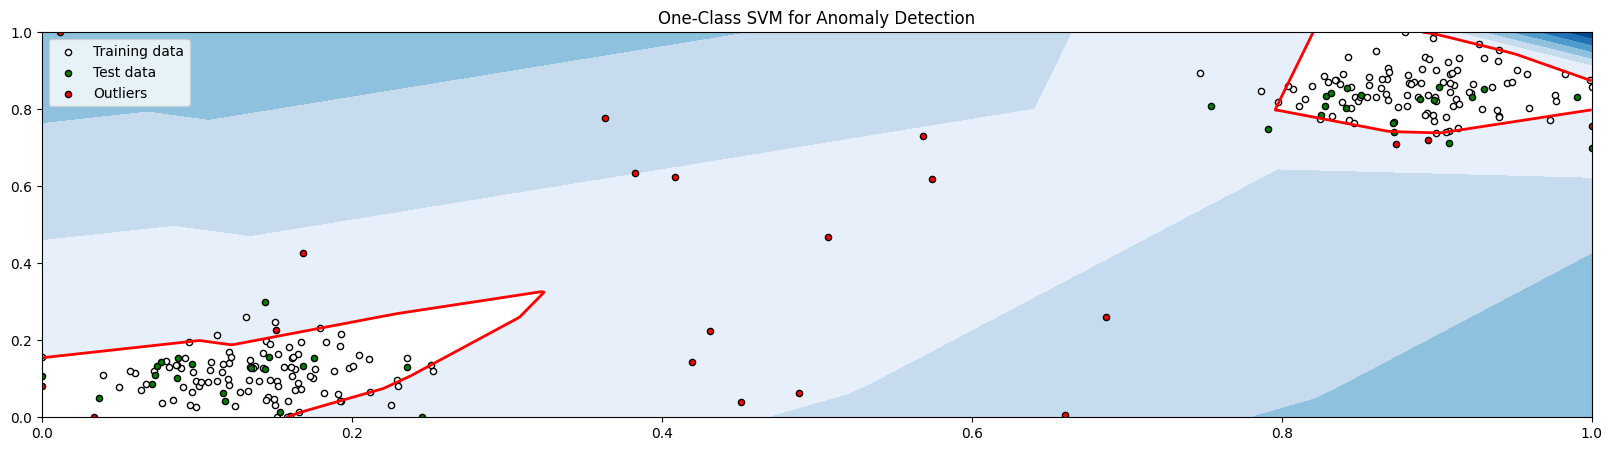

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=3,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

In [15]:
#three centriods

              precision    recall  f1-score   support

           0       0.28      0.95      0.44        20
           1       1.00      0.86      0.92       340

    accuracy                           0.86       360
   macro avg       0.64      0.90      0.68       360
weighted avg       0.96      0.86      0.90       360



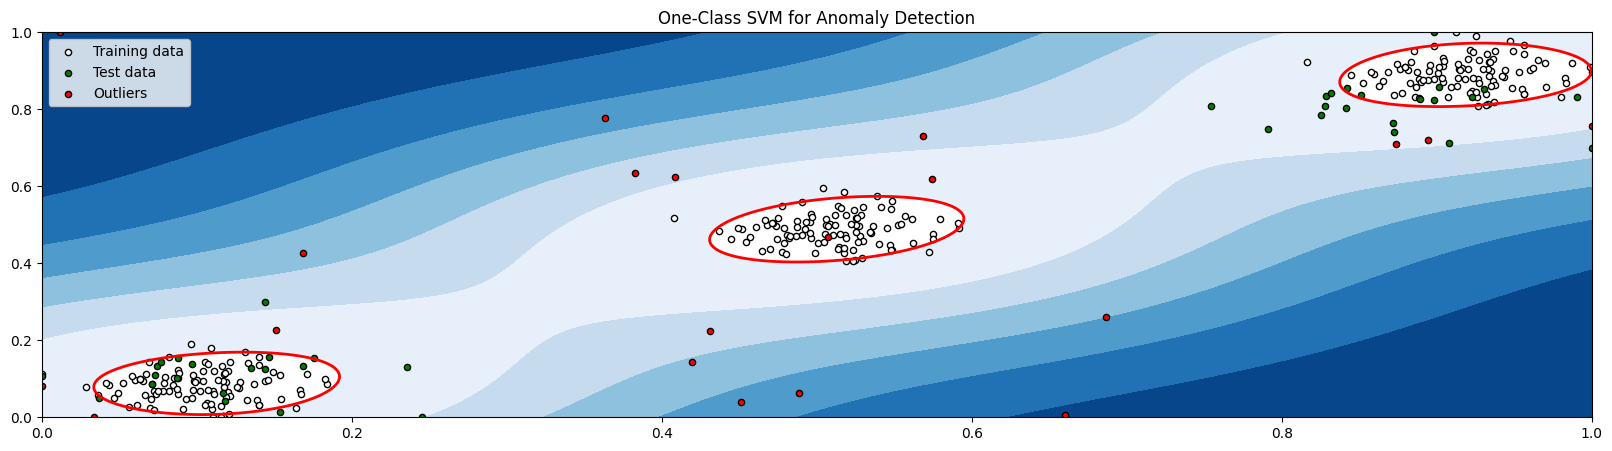

In [16]:
# Generate synthetic data
np.random.seed(42)
X_train = 0.1 * np.random.randn(100, 2)
X_train = np.r_[X_train -1, X_train , X_train+1]

X_test = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X_test + 2, X_test - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Standardize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_outliers = scaler.fit_transform(X_outliers)

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=10, nu=0.1)#gamma=10

# Train the model
oc_svm.fit(X_train)

plot_boundary(2,5)

              precision    recall  f1-score   support

           0       0.05      0.60      0.09        20
           1       0.93      0.32      0.48       340

    accuracy                           0.34       360
   macro avg       0.49      0.46      0.28       360
weighted avg       0.88      0.34      0.46       360



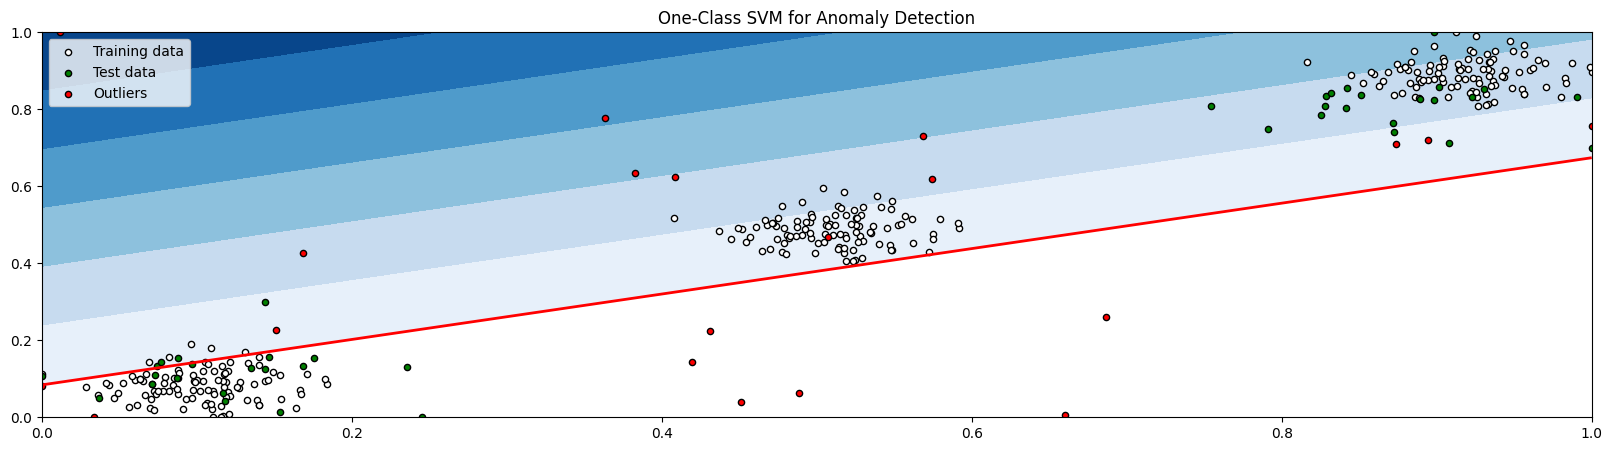

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=0,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.08      0.50      0.14        20
           1       0.96      0.65      0.78       340

    accuracy                           0.64       360
   macro avg       0.52      0.58      0.46       360
weighted avg       0.91      0.64      0.74       360



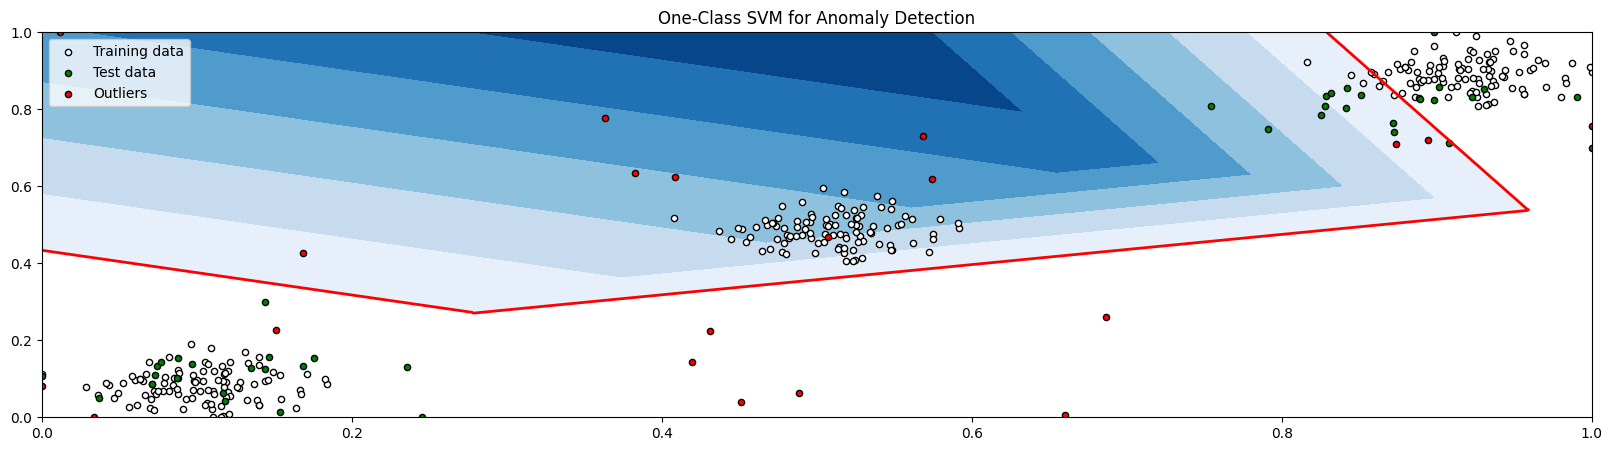

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=1,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.01, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.39      0.80      0.52        20
           1       0.99      0.93      0.96       340

    accuracy                           0.92       360
   macro avg       0.69      0.86      0.74       360
weighted avg       0.95      0.92      0.93       360



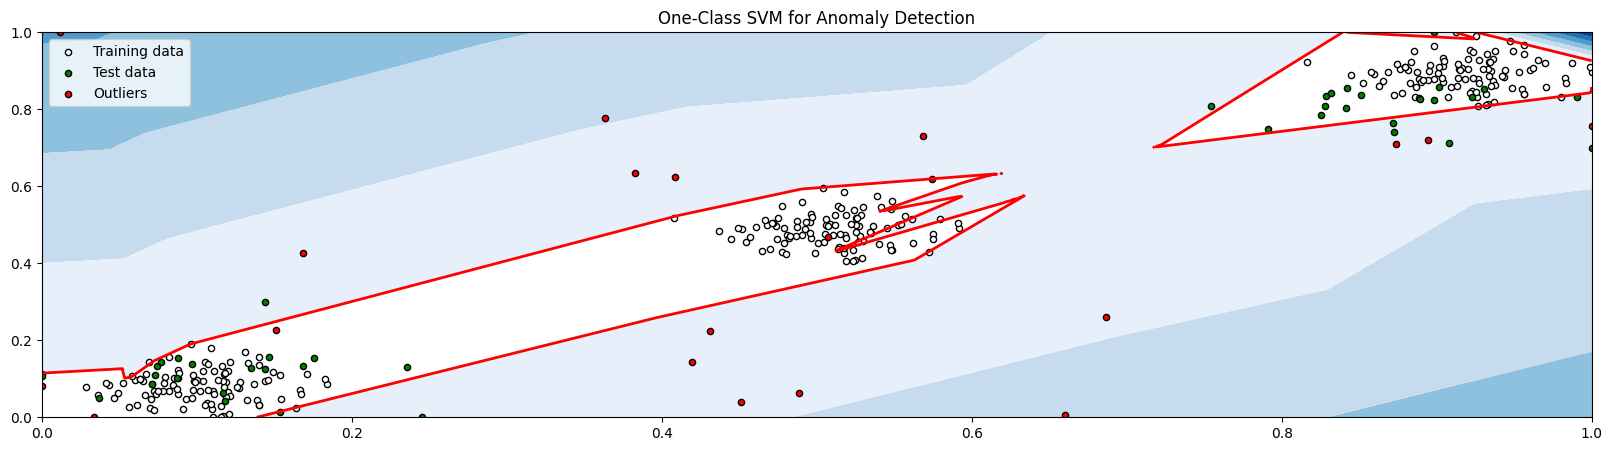

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=4,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.01, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)

              precision    recall  f1-score   support

           0       0.14      0.50      0.22        20
           1       0.97      0.87      0.92       440

    accuracy                           0.85       460
   macro avg       0.56      0.68      0.57       460
weighted avg       0.94      0.85      0.89       460



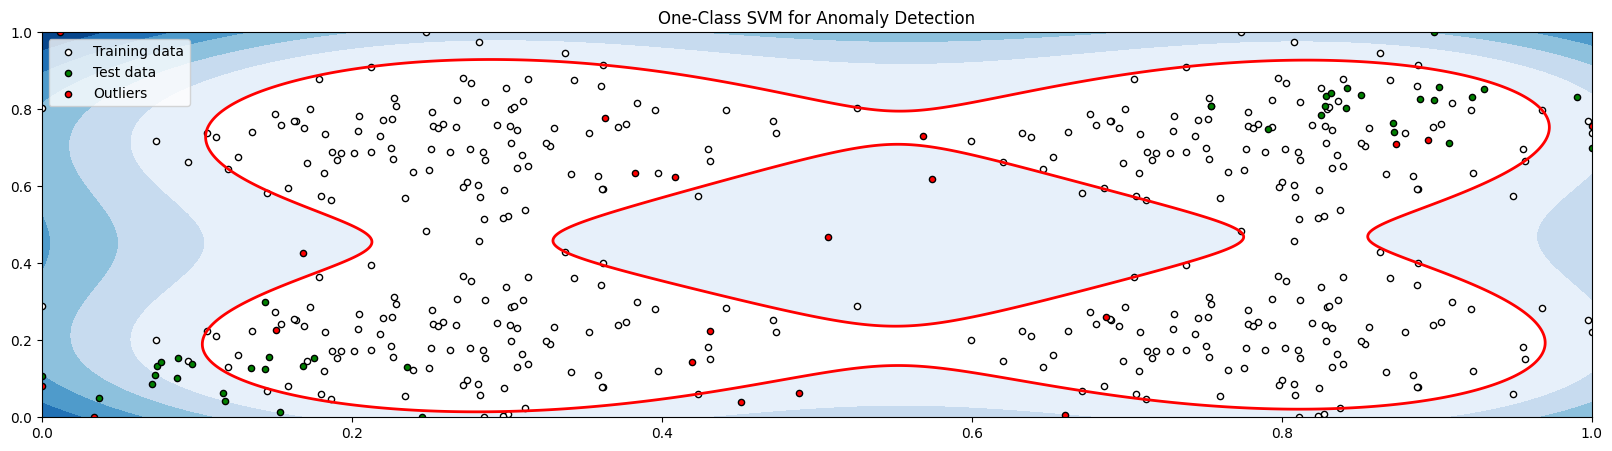

In [20]:
# Generate synthetic data
np.random.seed(42)
X_train = 0.2 * np.random.randn(100, 2)
X_train = np.r_[X_train +[0,1], X_train , X_train+[1,1], X_train+[1,0]]

X_test = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X_test + 2, X_test - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Standardize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_outliers = scaler.fit_transform(X_outliers)

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=10, nu=0.1)#gamma=10

# Train the model
oc_svm.fit(X_train)

plot_boundary(2,5)

              precision    recall  f1-score   support

           0       0.08      0.20      0.11        20
           1       0.96      0.89      0.92       440

    accuracy                           0.86       460
   macro avg       0.52      0.54      0.52       460
weighted avg       0.92      0.86      0.89       460



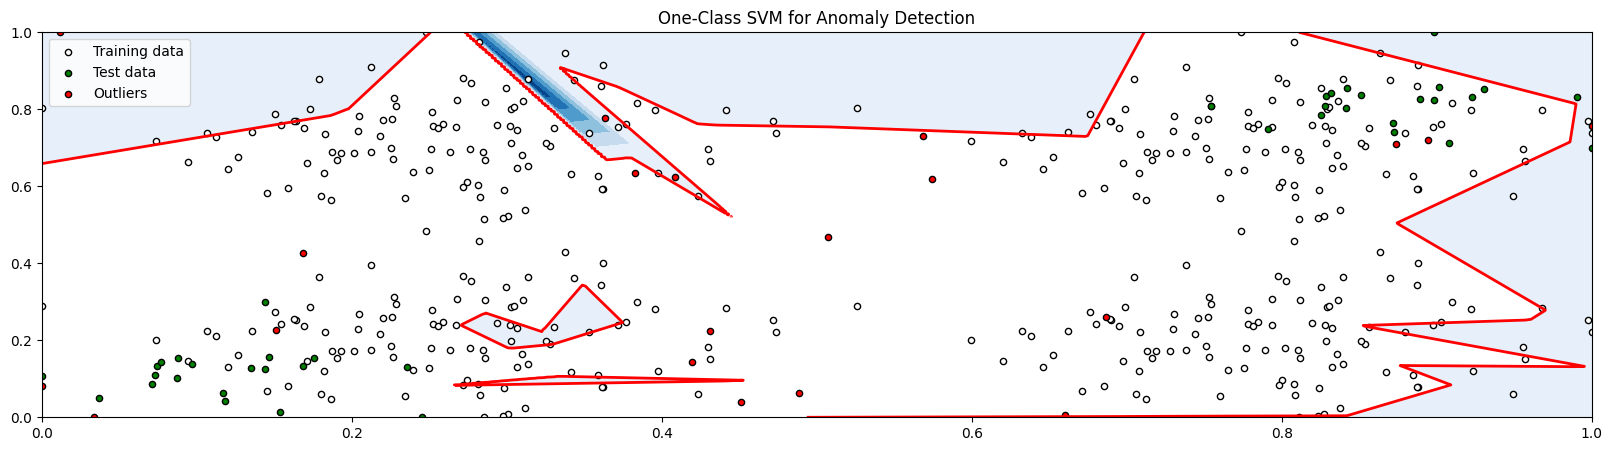

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', NBCS(k=4,type="adapt_ocs")), ('clf', OneClassSVM(nu=0.1, kernel="linear", gamma=0.1))]
oc_svm = Pipeline(estimators)

# Train the model
oc_svm=oc_svm.fit(X_train)

plot_boundary(2,1)